**Data Exploration**

In [1]:
# Utility Imports
import pandas as pd
import numpy as np

# Visualization Imports
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS 

# Mode-building Imports
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.preprocessing import OrdinalEncoder
from datetime import datetime

# Data preperation class
from model_tools_class import mt

# Reading in the data.
df = pd.read_csv('../data/train.csv')

def wrangle(df):
    '''
    This function wranlges/prepares the data for usage in the model.
    '''

    # The daily price of the AirBnb listing.
    df['price'] = df['log_price'].apply(lambda x : round(np.exp(x)))

    # Cleaning the amenities column.
    df['amenities'] = df['amenities'].apply(mt.clean)
    df['amenities'] = df['amenities'].apply(lambda x: len(x))

    # Applying the get_days function to create a new feature = total number of hosted days.
    df['host_since_days'] = df['host_since'].apply(mt.get_days)

    # Dropping redundant columns.
    df.drop(columns=['host_since','log_price','id','latitude','longitude','name','description','thumbnail_url','review_scores_rating','number_of_reviews','host_has_profile_pic','host_response_rate','last_review','first_review'],inplace=True)

    # A new column: Is the room isntantly bookable.
    df['instant_bookable'].replace(('f','t'),("False",'True'),inplace=True)

    # A new column: is the hosts' identity verified.
    df['host_identity_verified'].replace(('f','t'),("False",'True'),inplace=True)

    # Dropping null values
    df = df.dropna(axis=0)
    
    return df

df = wrangle(df)

In [2]:
# Splitting the data
Y = df['price']
X = df.drop(columns=['price'])

# moving price to the back of df
df['target/price'] = df['price']
df.drop(columns=['price'],inplace=True)

**Visualizations**

In [113]:
df

,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,host_identity_verified,instant_bookable,neighbourhood,zipcode,bedrooms,beds,host_since_days,target/price
0,Apartment,Entire home/apt,8,3,1.0,Real Bed,strict,True,NYC,True,False,Brooklyn Heights,11201,1.0,1.0,3341,150
1,Apartment,Entire home/apt,14,7,1.0,Real Bed,strict,True,NYC,False,True,Hell's Kitchen,10019,3.0,3.0,1419,169
2,Apartment,Entire home/apt,18,5,1.0,Real Bed,moderate,True,NYC,True,True,Harlem,10027,1.0,3.0,1670,145
3,House,Entire home/apt,15,4,1.0,Real Bed,flexible,True,SF,True,False,Lower Haight,94117.0,2.0,2.0,2209,750
4,Apartment,Entire home/apt,12,2,1.0,Real Bed,moderate,True,DC,True,True,Columbia Heights,20009,0.0,1.0,2221,115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74106,Apartment,Private room,0,1,1.0,Real Bed,flexible,False,NYC,True,False,Williamsburg,11206.0,1.0,1.0,2974,100
74107,Apartment,Entire home/apt,15,4,2.0,Real Bed,moderate,True,LA,False,False,Hermosa Beach,90254,2.0,4.0,1798,155
74108,Apartment,Entire home/apt,31,5,1.0,Real Bed,moderate,True,NYC,True,True,Williamsburg,11206.0,2.0,2.0,3380,185
74109,Apartment,Entire home/apt,15,2,1.0,Real Bed,strict,True,NYC,False,True,West Village,10011,0.0,2.0,1327,195


C:\Users\14045\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


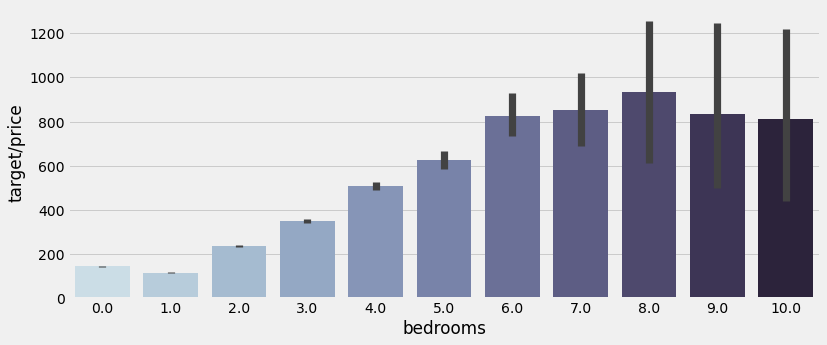

In [121]:
# Plotting the bedrroms against the price

def generate_hist(x, y):
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(12, 5))
    sns.barplot(x, y, palette="ch:s=.25,rot=-.25")
    
generate_hist(df['bedrooms'], df['target/price'])

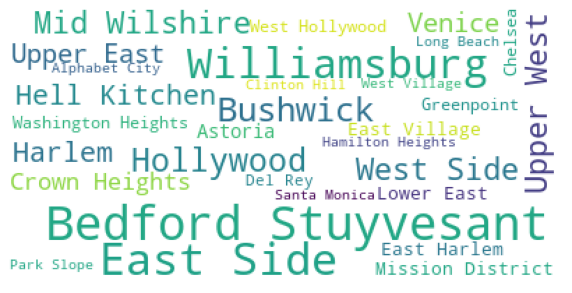

In [112]:
# Visualizing the 30 cities with the most rooms with a wordcloud.

words = df['neighbourhood'].to_string()

plt.subplots(figsize=(10, 10))

def generate_wordcloud(text): 
    '''
    This creates a function call that creates the wordcloud
    '''
    wordcloud = WordCloud(max_words=30, background_color='white',
                          relative_scaling = 1,
                          stopwords = stopwords
                          ).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

generate_wordcloud(words)

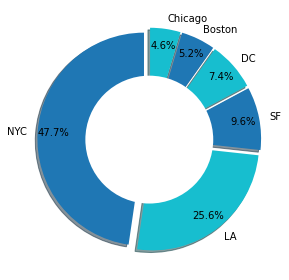

In [111]:
# Plotting the percentage of available rooms in the data with a pie chart.

cities = ['NYC', 'LA', 'SF', 'DC', 'Boston', 'Chicago']
colors = ['#1f77b4','#17becf', '#1f77b4','#17becf', '#1f77b4','#17becf']
explode = (0.05,0.05,0.05,0.05, 0.05, 0.05)
sizes = []

for x in df['city'].value_counts():
    sizes.append(x)

def generate_pie(sizes, colors, explode, size):
    '''
    This creates a function call that creates the pie chart
    '''
    
    # initializing the chart with the predefined variables
    plt.pie(sizes, colors=colors, labels=cities, 
            autopct='%1.1f%%', startangle=90, 
            pctdistance=0.85, explode=explode, 
            shadow=True, radius=1)
    
    # drawing circle
    centre_circle = plt.Circle((0,0),0.60,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    
    # increasing aspect ration
    ax1.axis('equal')  
    plt.tight_layout()
    plt.show()
    
generate_pie(sizes, colors, explode, sizes)

**Model Creation**

In [ ]:
X_strings = X.select_dtypes(include='object')
X_non_strings = X.select_dtypes(include=['int64','float'])
oe =OrdinalEncoder()
oe.fit(X_strings)
X_train = oe.transform(X_strings)

In [ ]:
X_train_whole = np.concatenate((X_train,X_non_strings),axis=1)

model_columns = X_strings.columns.append(X_non_strings.columns)

In [ ]:
model_columns

In [ ]:
input_dims = len(X_train_whole[0])

# Instantiating the model 
model = Sequential()

# Model Layers
model.add(Dense(input_dims,input_dim=input_dims, activation="relu", kernel_initializer='normal'))
model.add(Dense(1,activation="linear",kernel_initializer='normal'))

# Compiling the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

# Fitting the data to the model
model.fit(X_train_whole,Y,epochs=10, batch_size=32, validation_split = 0.2)

In [ ]:

def get_confirm_df(input_list_objects,input_list_numbers,string_value_list):
    df_rows = []
    for i in np.arange(9):
        df_rows.append((model_columns[i],string_value_list[i],input_list_objects[0][i]))
    for i in np.arange(9,len(model_columns)):
        df_rows.append((model_columns[i],input_list_numbers[i-9],input_list_numbers[i-9]))
    confirm_df = pd.DataFrame(df_rows,columns=['Variable','Value','Encoded'])
    return confirm_df


In [ ]:
from datetime import datetime
def get_prediction(df):
    string_variable_list = ['property_type','room_type','bed_type',
                   'cancellation_policy','city','host_identity_verified',
                   'instant_bookable','neighbourhood','zipcode']
    number_variable_list = ['amenities','accommodates','bathrooms','beds','bedrooms','host_since_days']
    number_value_list = []
    string_value_list = []
    for x in string_variable_list:
        string_value_list.append(df[x])
    for x in number_variable_list:
        if type(df[x]) != str and type(df[x]) != np.int64 and type(df[x]) != np.float64 and type(df[x]) != np.bool:
            number_value_list.append(mt.get_days(df[x]))
        else:
            number_value_list.append(df[x])
    string_vectorized= oe.transform(np.array(string_value_list).reshape(1,-1))
    whole_input_vector = string_vectorized[0].tolist() + number_value_list
    confirm_df = get_confirm_df(string_vectorized,number_value_list,string_value_list)
    
    prediction = model.predict(np.array(whole_input_vector).reshape(1,-1))
    return prediction[0][0],confirm_df

In [ ]:
predict, df_predict = get_prediction(test_df)

In [ ]:
df_predict

In [ ]:
predict